In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

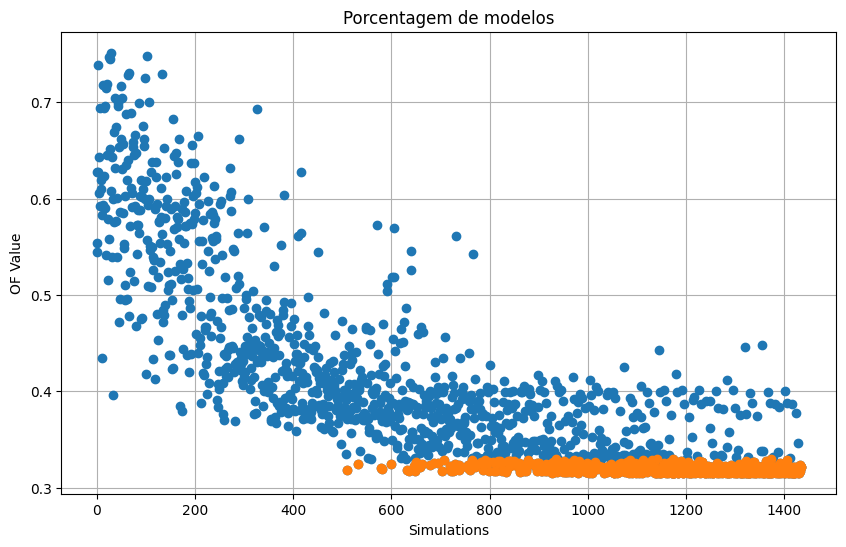

Número de componentes principais selecionados: 5
Variância explicada acumulada pelos componentes: 0.97


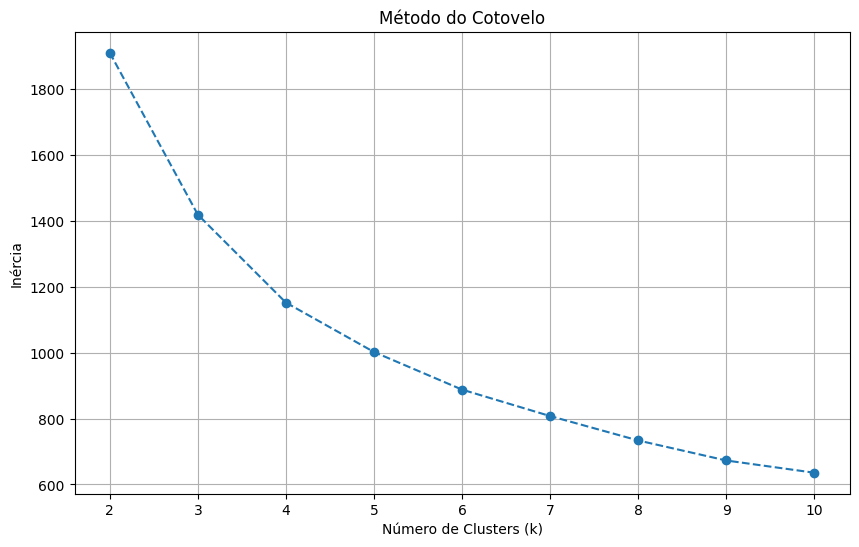

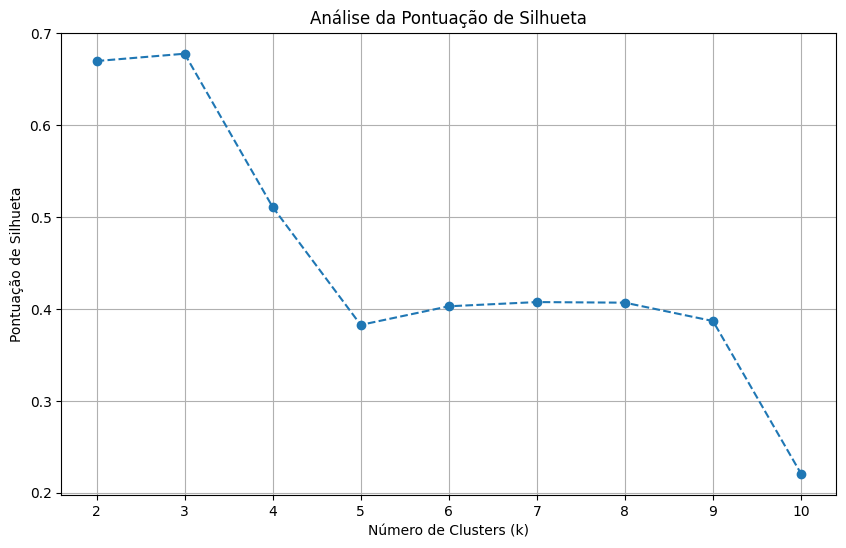

In [94]:
# --- Passo 1: Carregar e Preparar os Dados ---
file_path = '5Pocos_SemEustasia.xlsx'
df = pd.read_excel(file_path)

# Limpar colunas desnecessárias
df_cleaned = df.drop(['OutputPath', 'Ambiguity'], axis=1, errors='ignore')

if 'Unnamed: 0' in df_cleaned.columns:
    df_cleaned = df_cleaned.rename(columns={'Unnamed: 0': 'Simulation_ID'})
    df_cleaned = df_cleaned.set_index('Simulation_ID')


# Selecionar os melhores modelos (menor 'OF Value')
n_best = int(len(df_cleaned) * 0.3)
best_models = df_cleaned.nsmallest(n_best, 'OF Value').copy()
parameters = best_models.drop(['OF Value', 'Simulation'], axis=1)

plt.figure(figsize=(10, 6))
plt.plot(df_cleaned['Simulation'], df_cleaned['OF Value'], marker='o',  linestyle='None')
plt.plot(best_models['Simulation'], best_models['OF Value'], marker='o',  linestyle='None')
plt.xlabel('Simulations')
plt.ylabel('OF Value')
plt.title('Porcentagem de modelos')
plt.grid(True)
plt.show()

# Separar os parâmetros (X) do valor da função objetivo (y)
X = best_models.drop(['OF Value', 'Simulation'], axis=1)

# --- Passo 2: Padronizar os Dados ---
# Isto é importante para que o PCA e o K-Means funcionem corretamente
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# --- Passo 3: Redução de Dimensionalidade com PCA ---
# Reduzimos a dimensionalidade para facilitar o clustering e a visualização
# O PCA vai reter 95% da variância original dos dados
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Número de componentes principais selecionados: {pca.n_components_}")
print(f"Variância explicada acumulada pelos componentes: {np.sum(pca.explained_variance_ratio_):.2f}")

# --- Passo 4: Encontrar o Número Ideal de Clusters ---
# Usaremos dois métodos: o Método do Cotovelo e a Pontuação de Silhueta

# Método do Cotovelo (Elbow Method)
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.title('Método do Cotovelo')
plt.grid(True)
plt.show()

# Pontuação de Silhueta (Silhouette Score)
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Pontuação de Silhueta')
plt.title('Análise da Pontuação de Silhueta')
plt.grid(True)
plt.show()

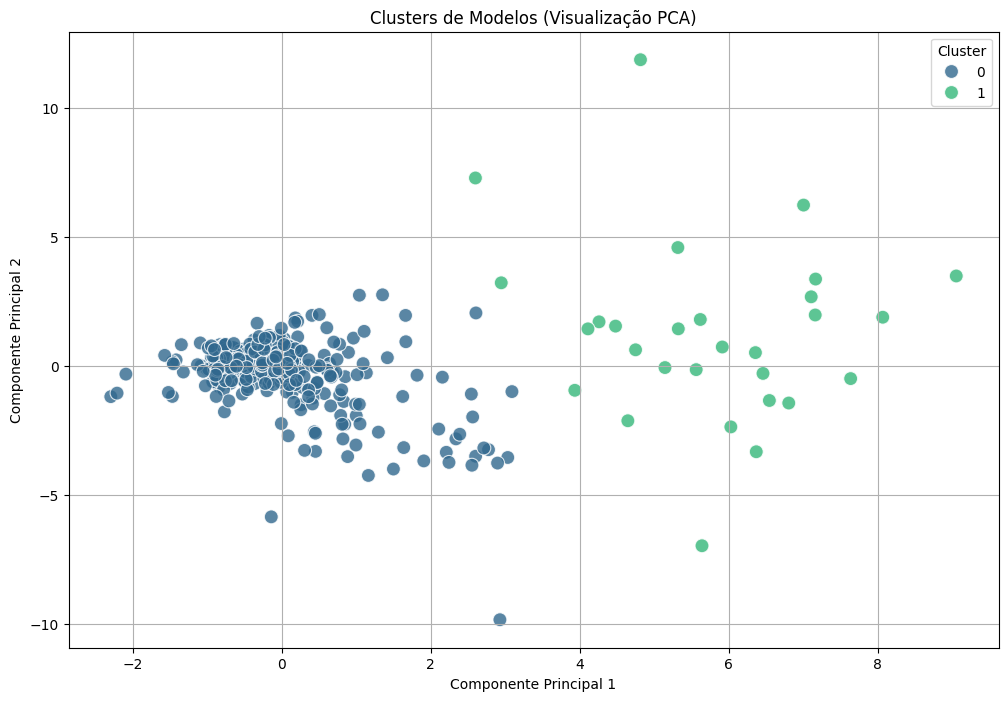

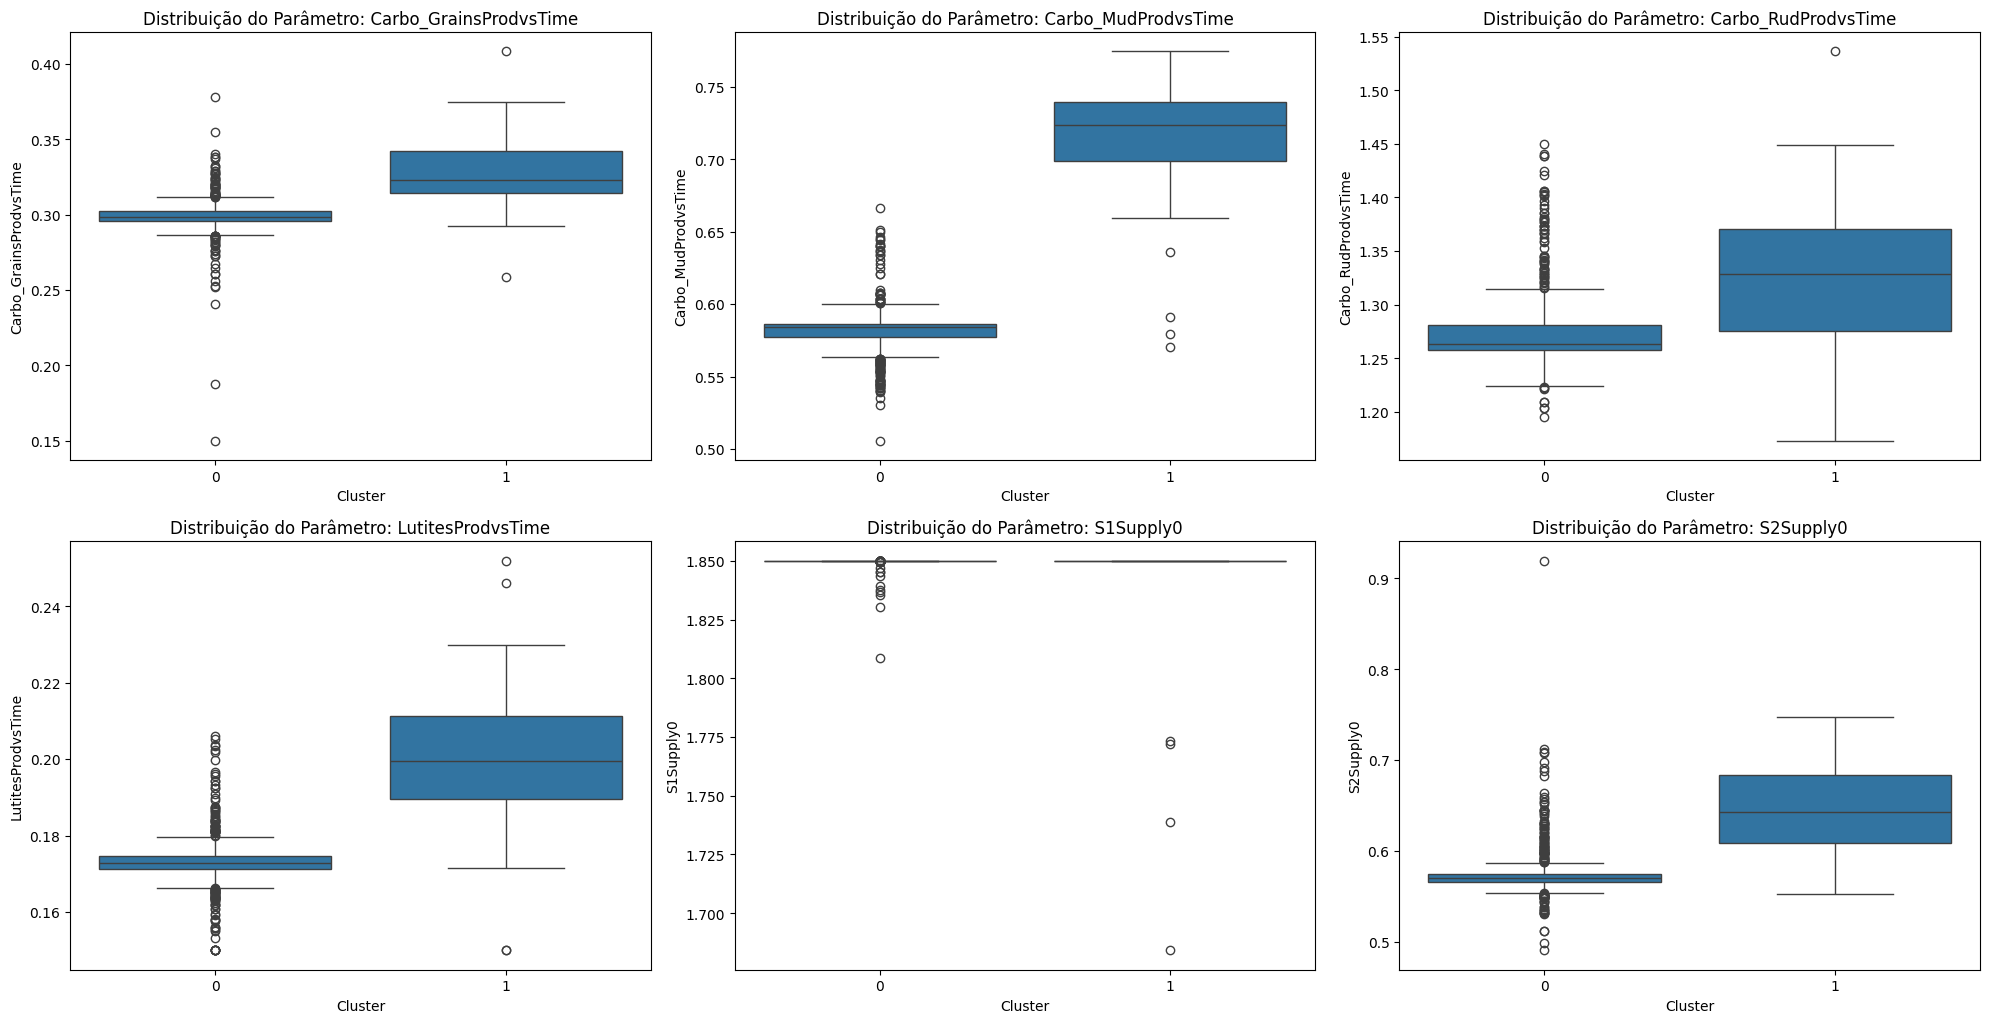

In [91]:
# --- Passo 5: Aplicar o Clustering K-Means ---
# Escolha o 'k' ideal com base nos gráficos (onde o cotovelo se forma ou a silhueta é máxima)
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
best_models['Cluster'] = kmeans.fit_predict(X_pca)

# --- Passo 6: Visualizar e Interpretar os Resultados ---

# Visualizar os clusters no espaço PCA
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=best_models['Cluster'], palette='viridis', s=100, alpha=0.8)
plt.title('Clusters de Modelos (Visualização PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Analisar a distribuição dos parâmetros em cada cluster
X_with_clusters = X.copy()
X_with_clusters['Cluster'] = best_models['Cluster']

# Criar boxplots para cada parâmetro
plt.figure(figsize=(20, 15))
for i, column in enumerate(X.columns):
    plt.subplot(3, 3, i + 1) # Ajuste o layout se tiver mais parâmetros
    sns.boxplot(x='Cluster', y=column, data=X_with_clusters)
    plt.title(f'Distribuição do Parâmetro: {column}')
plt.tight_layout()
plt.show()

In [92]:
# --- Passo 5: Gerar o Ficheiro CSV Final ---
# Ordenar os resultados por cluster para facilitar a sua análise
best_models_sorted = best_models.sort_values(by=['Cluster', 'OF Value'])

# Salvar o dataframe num novo ficheiro CSV
output_filename = 'simulacoes_por_cluster.xlsx'
best_models_sorted.to_excel(output_filename)

print(f"\nANÁLISE CONCLUÍDA!")
print(f"Foi criado o ficheiro '{output_filename}' com os resultados.")


# Exibir os centróides (valores médios dos parâmetros) de cada cluster
centroids_pca = kmeans.cluster_centers_
centroids = scaler.inverse_transform(pca.inverse_transform(centroids_pca))
centroid_df = pd.DataFrame(centroids, columns=X.columns)
print("\n--- Centróides dos Clusters (Parâmetros dominantes de cada grupo) ---")
print(centroid_df)

# Exibir o número de modelos em cada cluster
print("\n--- Tamanho de cada cluster ---")
print(best_models['Cluster'].value_counts())


ANÁLISE CONCLUÍDA!
Foi criado o ficheiro 'simulacoes_por_cluster.xlsx' com os resultados.

--- Centróides dos Clusters (Parâmetros dominantes de cada grupo) ---
   Carbo_GrainsProdvsTime  Carbo_MudProdvsTime  Carbo_RudProdvsTime  \
0                0.299029             0.582043             1.275116   
1                0.328832             0.707964             1.321941   

   LutitesProdvsTime  S1Supply0  S2Supply0  
0           0.173142   1.849802   0.575110  
1           0.200531   1.835117   0.647732  

--- Tamanho de cada cluster ---
Cluster
0    688
1     29
Name: count, dtype: int64


In [60]:
# 7.1: Encontrar e comparar a melhor simulação de cada cluster
print("\n--- Melhores Simulações ('Campeãs') de Cada Cluster ---")
best_of_each_cluster = best_models.loc[best_models.groupby('Cluster')['OF Value'].idxmin()]
print(best_of_each_cluster)

# 7.2: Identificar o parâmetro dominante para cada cluster
print("\n--- Análise de Parâmetros Dominantes por Cluster ---")
# Usamos os dados padronizados para ver os desvios da média geral
X_scaled_df = pd.DataFrame(X_scaled, columns=parameters.columns)
X_scaled_df['Cluster'] = best_models['Cluster']
scaled_centroids = X_scaled_df.groupby('Cluster').mean()

for i, row in scaled_centroids.iterrows():
    # Encontra o parâmetro com o maior desvio (positivo ou negativo)
    dominant_param = row.abs().idxmax()
    param_value = row[dominant_param]
    direction = "alto" if param_value > 0 else "baixo"
    print(f"Cluster {i}: Parâmetro mais dominante é '{dominant_param}', com um valor padronizado significativamente {direction} ({param_value:.2f}).")


# --- PASSO 4: Criar e Salvar a Planilha Excel ---

# 1. Encontrar o índice da melhor simulação (menor 'OF Value') em cada cluster
idx_melhores_simulacoes = best_models.groupby('Cluster')['OF Value'].idxmin()

# 2. Selecionar as linhas completas dessas simulações
melhores_simulacoes_df = best_models.loc[idx_melhores_simulacoes]

# 3. Definir o nome do ficheiro de saída
nome_arquivo_excel = 'melhores_simulacoes_por_grupo.xlsx'

# 4. Salvar o resultado num ficheiro .xlsx
melhores_simulacoes_df.to_excel(nome_arquivo_excel)

print(f"Arquivo '{nome_arquivo_excel}' criado com sucesso!")


--- Melhores Simulações ('Campeãs') de Cada Cluster ---
               Carbo_GrainsProdvsTime  Carbo_MudProdvsTime  \
Simulation_ID                                                
Sim1175                      0.293477             0.585868   
Sim1251                      0.296309             0.588728   
Sim1349                      0.296064             0.585279   
Sim1309                      0.297571             0.585329   
Sim1328                      0.296231             0.584592   

               Carbo_RudProdvsTime  LutitesProdvsTime  S1Supply0  S2Supply0  \
Simulation_ID                                                                 
Sim1175                   1.260608           0.172203    1.85000   0.568670   
Sim1251                   1.258387           0.170591    1.85000   0.567372   
Sim1349                   1.259079           0.173483    1.85000   0.572610   
Sim1309                   1.256837           0.172932    1.85000   0.570009   
Sim1328                   1.257417